In [1]:
# シミュレーションによる価値関数がなぜギザギザなのか考える

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sys
sys.path.append('../../module/')

from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam
import csv
from util import *
import gym2
from rl2.agents import selfDDPGAgent, selfDDPGAgent2
from rl2.memory import SequentialMemory

Using TensorFlow backend.
Using TensorFlow backend.


In [3]:
# GymのPendulum環境を作成
env = gym2.make("Pendulum-v2")

# 取りうる”打ち手”のアクション数と値の定義
nb_actios = 2
ACT_ID_TO_VALUE = {0: [-1], 1: [+1]}

In [172]:
def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

def branch_actor(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input) # 実質的なinput layer
    
    x1 = Dense(8, activation="relu")(x)
    x1 = Dense(8, activation="relu")(x1)
    x1 = Dense(1, activation="multiple_tanh")(x1) # action signal
    
    x2 = Dense(8, activation="relu")(x)
    x2 = Dense(8, activation="relu")(x2)
    x2 = Dense(1, activation="tau_output")(x2) # tau
    
    output = concatenate([x1, x2])
    actor = Model(inputs=action_input, outputs=output)
    return actor

def split_params(tw):
    action_tw = []
    tau_tw = []
    for i in range(len(tw)):
        if i % 4 < 2:
            action_tw.append(tw[i])
        else:
            tau_tw.append(tw[i])
    return action_tw, tau_tw

def agent2(a_shape, s_shape):
    actor = branch_actor(a_shape, s_shape)
    critic,  critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = selfDDPGAgent2(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory,
        original_noise=True,
        action_clipper=[-10., 10.],
        tau_clipper=[0.001, 1.],
        params_logging=False,
        gradient_logging=False,
        batch_size=128,
    )
    return agent

In [5]:
# agent compilation
l = 1.
a = agent2((2,), (2,))
actor_optimizer, critic_optimizer = Adam(lr=100., clipnorm=1.), Adam(lr=0.001, clipnorm=1.) # actorの方は何でもいい
optimizer = [actor_optimizer, critic_optimizer]
a.compile(optimizer=optimizer, metrics=["mse"], action_lr=0.0001, tau_lr=0.001)

In [156]:
# value_function_network
def value_model(s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input) # 実質的なinput layer
    
    x = Dense(32, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x) # action signal
    
    output = x
    value = Model(inputs=action_input, outputs=output)
    return value

def Q_model(s_shape, a_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    
    x = Dense(8, activation="relu")(x)
    x = Dense(8, activation="relu")(x)
    x = Dense(1, activation="linear")(x) # action signal
    
    output = x
    value = Model(inputs=[action_input, observation_input], outputs=output)
    value.summary()
    return value

def interaction(agent, env, start_state, gamma=.99, step_limit=1000):
    rewards = []
    env.reset()
    env.set_state(start_state)
    episode_reward = 0
    for steps in range(step_limit):
        reward = 0
        x = env.state
        a_agent, tau = agent.forward(x)
        action_repetition = int(np.ceil(20 * tau))  # minimum natural number which makes `dt` smaller than 0.005
        dt = tau/action_repetition
        for p in range(action_repetition):
            _,r,_,_ = env.step(np.array([a_agent]), dt, tau)
            reward += r
        reward *= dt
        reward += - tau * 0.01 * a_agent**2 + l * tau # step reward
        rewards.append(reward)
        #if steps < 5000:
            #print(steps, reward, pow(gamma, steps) * reward)

        episode_reward += pow(gamma, steps) * reward
    
    return episode_reward


## `self_trigger7`

In [ ]:
%%time
# make train_data
a.actor.load_weights('./saved_agent/learned_self_clipped7_actor.h5')

values = []

th = np.linspace(-np.pi, np.pi, 100)
thd = np.linspace(-2*np.pi, 2*np.pi, 100)

TH, THD = np.meshgrid(th, thd)
torques, taus = [], []

for state in zip(TH.flatten(), THD.flatten()):
    state = np.array(state)
    v = interaction(a, env, state)
    values.append(v)

values = np.array(values)

In [134]:
# write
with open('./csv/value_true7.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(values)

In [10]:
# read 
with open('./csv/value_true7.csv', 'r') as f:
    reader = csv.reader(f)
    values = np.array([r for r in reader]).astype('float')

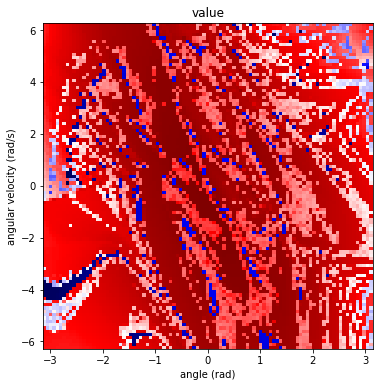

In [137]:
values
fig = plt.figure(figsize=(13,6))
ax1 = fig.add_subplot(121)
ax1.set_xlabel('angle (rad)')
ax1.set_ylabel('angular velocity (rad/s)')
ax1.set_title('value')

ax1.pcolormesh(TH, THD, values.reshape((100,100)), cmap='seismic')

(array([  96.,  139.,  176.,   45.,  389.,  927., 1711., 1617., 2042.,
        2858.]),
 array([40.88671393, 43.86692312, 46.8471323 , 49.82734149, 52.80755067,
        55.78775985, 58.76796904, 61.74817822, 64.72838741, 67.70859659,
        70.68880578]),
 <a list of 10 Patch objects>)

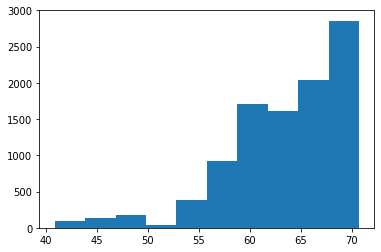

In [138]:
plt.hist(values)

In [111]:
value_function = value_model((2,))
value_function.compile(loss='mean_squared_error',optimizer='adam')
print(value_function)

## `self_trigger1`

In [29]:
a.actor.load_weights('./saved_agent/learned_self_clipped_actor.h5')


with open('./csv/value_true1.csv', 'r') as f:
    reader = csv.reader(f)
    values = np.array([r for r in reader]).astype('float')

th = np.linspace(-np.pi, np.pi, 100)
thd = np.linspace(-2*np.pi, 2*np.pi, 100)

TH, THD = np.meshgrid(th, thd)

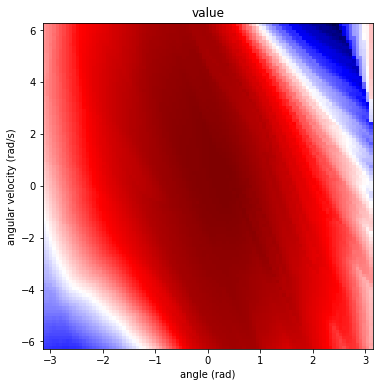

In [30]:
fig = plt.figure(figsize=(13,6))
ax1 = fig.add_subplot(121)
ax1.set_xlabel('angle (rad)')
ax1.set_ylabel('angular velocity (rad/s)')
ax1.set_title('value')

ax1.pcolormesh(TH, THD, values.reshape((100,100)), cmap='seismic')

### Q関数を学習する

In [157]:
Q_nn = Q_model((2,), (2,))
Q_nn.compile(loss='mse', optimizer=Adam(lr=0.001, clipnorm=1.))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           (None, 1, 2)         0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           (None, 2)            0                                            
__________________________________________________________________________________________________
flatten_19 (Flatten)            (None, 2)            0           input_23[0][0]                   
__________________________________________________________________________________________________
concatenate_6 (Concatenate)     (None, 4)            0           input_22[0][0]                   
                                                                 flatten_19[0][0]                 
__________

In [92]:
# 教師データ
rewards = []
actions = []
for state in zip(TH.flatten(), THD.flatten()):
    state = np.array(state)
    action = a.forward(state)
    r = interaction(a, env, state, step_limit=1)
    rewards.append(r)
    actions.append(action)

rewards = np.array(rewards).reshape(TH.shape)
actions = np.array(actions)

In [166]:
batch_size = 10
gamma = 0.99
indices = np.random.choice(range(10000),batch_size,replace=False)
states = np.vstack((TH.flatten(), THD.flatten())).T
batch = [states[indices], actions[indices], rewards.flatten()[indices], values[0][indices]]
inputs = [np.array(batch[1]), np.array([batch[0]]).reshape(10,1,2)]

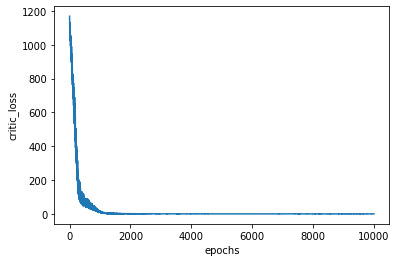

In [168]:
# 学習
a.actor.load_weights('./saved_agent/learned_self_clipped_actor.h5')
batch_size = 64
gamma = 0.99
indices = np.random.choice(range(10000),batch_size,replace=False)
states = np.vstack((TH.flatten(), THD.flatten())).T
batch = [states[indices], actions[indices], rewards.flatten()[indices], values[0][indices]]

epochs = 10000
losses = []
for _ in range(epochs):
    indices = np.random.choice(range(10000),batch_size,replace=False)
    batch = [states[indices], actions[indices], rewards.flatten()[indices], values[0][indices]]
    
    inputs = [np.array(batch[1]), np.array([batch[0]]).reshape(batch_size, 1, 2)]
    teacher = batch[2] + gamma * batch[3]
    
    loss = Q_nn.train_on_batch(inputs, teacher)
    losses.append(loss)
    
plt.plot(losses)
plt.xlabel('epochs')
plt.ylabel('critic_loss')
plt.show()

In [169]:
Q_nn.save_weights('./saved_agent/q_function_self1.h5')

## 方策勾配を計算する

In [174]:
import tensorflow as tf
from keras2.optimizers import Optimizer
import keras2.backend as K

def calculate_gradient(target_func, params, state0_batch, combined_input_tensor):
    dummy_optimizer = Optimizer()
    gradient_tensors = dummy_optimizer.get_gradients(target_func, params)
    
    gradient_calculate_function = _gradient_calculate_function(combined_input_tensor, gradient_tensors)
    gradient_value = gradient_calculate_function([state0_batch])
    
    return gradient_value

def _gradient_calculate_function(combined_input_tensor, gradient_tensors):
    # function input
    input_tensors = [combined_input_tensor[1]]

    # tensorflow running function
    gradient_calculate_function = K.function(input_tensors, gradient_tensors)
    return gradient_calculate_function

def flatten_gradient(gradient_values):
    if len(gradient_values[0].shape) == 2:
        g_array = gradient_values[0].flatten()
    else:
        g_array = gradient_values[0]
    for g in gradient_values[1:]:
        if len(g.shape) == 2:
            g = g.flatten()
        g_array = np.hstack((g_array, g))
    return g_array

state_input = tf.placeholder(tf.float32, shape=(None, 1, 2))
actor_output = a.actor(state_input)
combined_input_tensor = [actor_output, state_input]
critic_output_tensor = Q_nn(combined_input_tensor)
loss = -K.mean(critic_output_tensor)
action_tw, tau_tw = split_params(a.actor.trainable_weights)

In [176]:
# state batch with policy depended distribution
# 期待値を変えるならここを計算

states_batch = []
for i in range(500):
    env.reset()
    time_limit = 10
    acc_time = 0
    while True:
        x = env.state
        states_batch.append([x[0], x[1]])
        a_agent, tau = a.actor.predict_on_batch(np.array([[x]]))[0]
        action_repetition = int(np.ceil(200 * tau))  # minimum natural number which makes `dt` smaller than 0.005
        dt = tau / action_repetition
        acc_time += tau
        for p in range(action_repetition):
            _,_,_,_ = env.step(np.array([a_agent]), dt, tau)
        if acc_time > time_limit:
            break
    print('\r' + f'{i*2} %', end='')
states_batch = np.array(states_batch)
print()
print(states_batch.shape)

998 %
(14288, 2)


In [177]:
# batch gradient

# action_gradient for Q-function
action_gradient = calculate_gradient(loss, action_tw, states_batch, combined_input_tensor)
action_gradient_array = flatten_gradient(action_gradient)
print(action_gradient_array.shape, np.linalg.norm(action_gradient_array))
    
print()
# tau_gradient for Q-function
tau_gradient = calculate_gradient(loss, tau_tw, states_batch, combined_input_tensor)
tau_gradient_array = flatten_gradient(tau_gradient)
print(tau_gradient_array.shape, np.linalg.norm(tau_gradient_array))

(105,) 14.005304

(105,) 8.724301


# 以下検証

In [27]:
# agent setup
a.load_weights('./saved_agent/learned_self_clipped.h5')
a.training = False

36.08192164343578
36.08808603859671


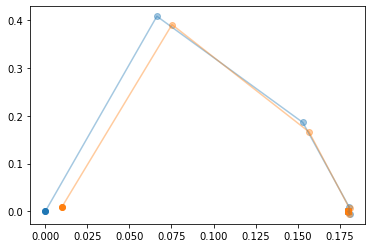

CPU times: user 6.46 s, sys: 414 ms, total: 6.87 s
Wall time: 6.67 s


In [28]:
%%time
# experiment

# 近い二つの状態のパスを比べる
l = 1.

view_path = True
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

# step wise evaluation

step_limit = 2000
n_episodes = 2
gamma = .99
average_reward = 0

start_point = np.array([[.0, .0],[.01, .01]])


for ep in range(n_episodes):
    state_log = []
    rewards = []
    env.reset()
    #env.set_state(np.random.uniform(low=-np.array([np.pi,2*np.pi]), high=np.array([np.pi,2*np.pi])))
    #env.set_state(np.array([0.,0.]))
    env.set_state(start_point[ep])
    episode_reward = 0
    for steps in range(step_limit):
        reward = 0
        x = env.state
        a_agent, tau = a.forward(x)
        state_log.append(x)
        action_repetition = int(np.ceil(20 * tau))  # minimum natural number which makes `dt` smaller than 0.005
        dt = tau/action_repetition
        for p in range(action_repetition):
            _,r,_,_ = env.step(np.array([a_agent]), dt, tau)
            reward += r
        reward *= dt
        reward += - tau * 0.01 * a_agent**2 + l * tau # step reward
        rewards.append(reward)
        #if steps < 5000:
            #print(steps, reward, pow(gamma, steps) * reward)

        episode_reward += pow(gamma, steps) * reward
    print(episode_reward)
    average_reward += episode_reward / n_episodes
    state_log = np.array(state_log)
    if view_path:
        plt.scatter(state_log[:,0], state_log[:,1], alpha=0.4, color=cycle[ep])
        plt.plot(state_log[:,0], state_log[:,1], alpha=0.4, color=cycle[ep])
        plt.scatter(state_log[0,0], state_log[0,1], marker='o', color=cycle[ep])
        plt.scatter(state_log[-1,0], state_log[-1,1], marker='x', color=cycle[ep])

if view_path:
    plt.show()

In [114]:
th = np.linspace(-np.pi, np.pi, 100)
thd = np.linspace(-2*np.pi, 2*np.pi, 100)

TH, THD = np.meshgrid(th, thd)
torques, taus = [], []

for state in zip(TH.flatten(), THD.flatten()):
    state = np.array(state)
    action = a.forward(state)
    torques.append(action[0])
    taus.append(action[1])

torques = np.array(torques).reshape(TH.shape)
taus = np.array(taus).reshape(TH.shape)

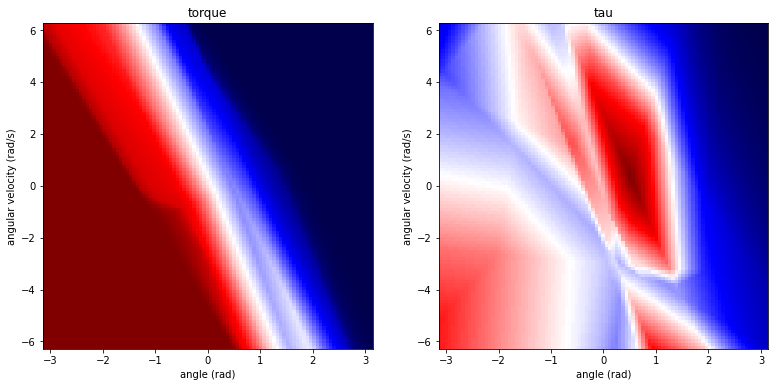

In [115]:
fig = plt.figure(figsize=(13,6))
ax1 = fig.add_subplot(121)
ax1.set_xlabel('angle (rad)')
ax1.set_ylabel('angular velocity (rad/s)')
ax1.set_title('torque')

ax1.pcolormesh(TH, THD, torques, cmap='seismic')

ax2 = fig.add_subplot(122)
ax2.set_xlabel('angle (rad)')
ax2.set_ylabel('angular velocity (rad/s)')
ax2.set_title('tau')

ax2.pcolormesh(TH, THD, taus, cmap='seismic')
plt.show()

In [105]:
%%time

# どのくらいのstep数で切るのが妥当？
# experiment

# 近い二つの状態のパスを比べる
l = 1.

view_path = True
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

# step wise evaluation

start_point = np.array([[.0, .0], [2.0, -1.0], [-2.0, 1.0]])
step_limit = 5000
n_episodes = len(start_point)
gamma = .99
average_reward = 0
rewardss = []


for ep in range(n_episodes):
    state_log = []
    rewards = []
    env.reset()
    env.set_state(start_point[ep])
    episode_reward = 0
    for steps in range(step_limit):
        reward = 0
        x = env.state
        a_agent, tau = a.forward(x)
        state_log.append(x)
        action_repetition = int(np.ceil(20 * tau))  # minimum natural number which makes `dt` smaller than 0.005
        dt = tau/action_repetition
        for p in range(action_repetition):
            _,r,_,_ = env.step(np.array([a_agent]), dt, tau)
            reward += r
        reward *= dt
        reward += - tau * 0.01 * a_agent**2 + l * tau # step reward
        rewards.append(reward)
        #if steps < 5000:
            #print(steps, reward, pow(gamma, steps) * reward)

        episode_reward += pow(gamma, steps) * reward
    print(episode_reward)
    rewardss.append(rewards)

36.08192171081065
33.80125436189932
34.035519305852425
CPU times: user 17.2 s, sys: 936 ms, total: 18.2 s
Wall time: 17.6 s


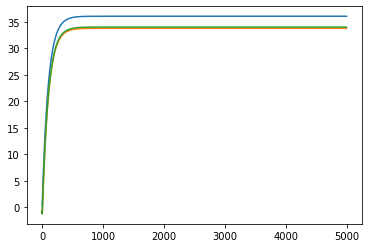

In [107]:
for rewards in rewardss:
    eps = 0
    discounts = []
    for i,r in enumerate(rewards):
        eps += pow(.99,i) * r
        discounts.append(eps)
    plt.plot(discounts)
    
# 1000もあれば十分